# Import Libraries

In [18]:
# Imports
import os, warnings, cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import pandas as pd
from os import listdir
from os.path import isfile, join
from shutil import rmtree
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification

main_path = '/kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K'
sub_dir =os.listdir(main_path)

Data_df=pd.DataFrame({'ID': [], 'Class':[]})

for subdir in sub_dir:
    mypath = join(main_path,subdir)
    files=[f for f in listdir(mypath)]
    classes=[subdir for c in files]
    files_df = pd.DataFrame({'ID':files, 'Class':classes})
    Data_df = Data_df.append(files_df)

Data_df

/tmp/ipykernel_28/3198776326.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_df = Data_df.append(files_df)
/tmp/ipykernel_28/3198776326.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_df = Data_df.append(files_df)
/tmp/ipykernel_28/3198776326.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_df = Data_df.append(files_df)
/tmp/ipykernel_28/3198776326.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_df = Data_df.append(files_df)
/tmp/ipykernel_28/3198776326.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_

,ID,Class
0,MUC-GQLYEALK.tif,MUC
1,MUC-FYTGWFGD.tif,MUC
2,MUC-AVNDTFWS.tif,MUC
3,MUC-DQPFGFLS.tif,MUC
4,MUC-FNEDYLHG.tif,MUC
...,...,...
10441,STR-NQFCFNPH.tif,STR
10442,STR-KPWLGGCI.tif,STR
10443,STR-FFCLCFPE.tif,STR
10444,STR-HGPELQKY.tif,STR


In [19]:
# Distribution of the Classes
class_of_patch = Data_df.Class.value_counts()
print('the distribution of classes:\n{}'.format(class_of_patch[::-1]))

the distribution of classes:
NORM     8763
MUC      8896
ADI     10407
STR     10446
BACK    10566
DEB     11512
LYM     11557
MUS     13536
TUM     14317
Name: Class, dtype: int64


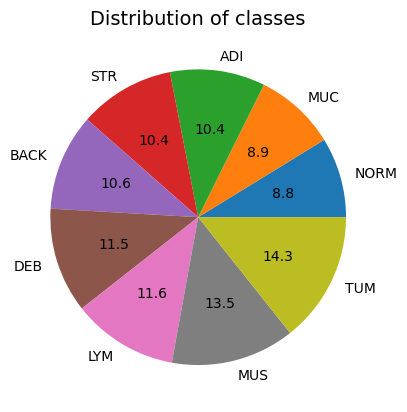

In [20]:
class_of_patch_labels = ['NORM','MUC','ADI','STR','BACK','DEB','LYM','MUS','TUM']
class_of_patch_values = class_of_patch[::-1]

plt.pie(class_of_patch_values, labels=class_of_patch_labels, startangle=0, autopct='%1.1f')
plt.title('Distribution of classes', fontsize=14)
plt.show()


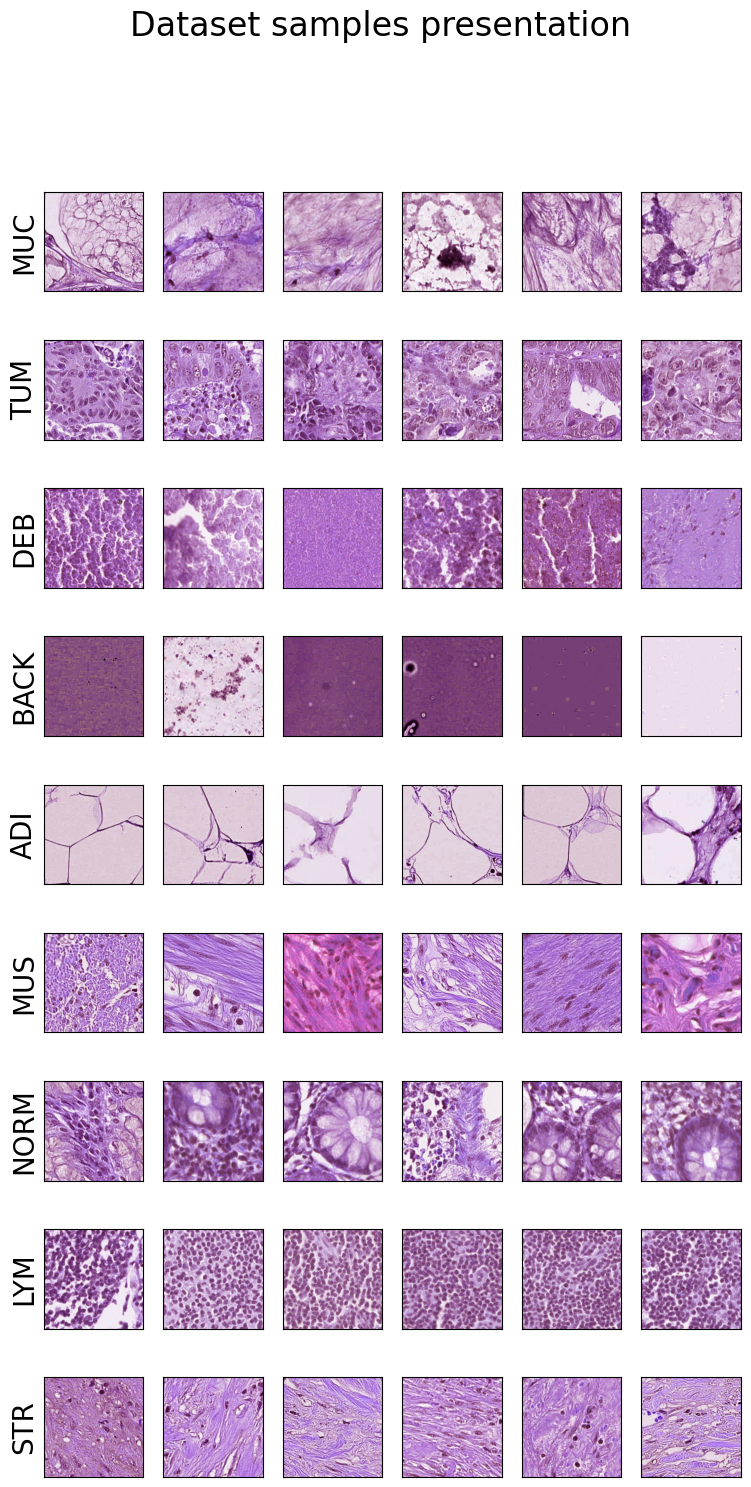

In [21]:
fig, axs = plt.subplots(9, 6, figsize=(9, 17))
fig.suptitle('Dataset samples presentation', size=24)

for i, cls in enumerate(sub_dir):
    samples = Data_df[Data_df['Class'] == cls].sample(6)
    for j, img_path in enumerate(samples['ID']):
        img = cv2.imread(join(main_path, cls, img_path))
        axs[i, j].imshow(img)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
    axs[i, 0].set_ylabel(cls, size=20)

In [22]:
# Split into train and test
train_df, test_df = train_test_split(Data_df, test_size=0.15, random_state=42, shuffle=True, stratify=Data_df['Class'])

# Split train set into train and validation
train_df, val_df = train_test_split(train_df, test_size=0.176471, random_state=42, shuffle=True, stratify=train_df['Class'])

Class Distribution of Training Examples:
TUM     10021
MUS      9475
LYM      8090
DEB      8058
BACK     7396
STR      7312
ADI      7285
MUC      6228
NORM     6134
Name: Class, dtype: int64 

Class Distribution of Validation Examples:
TUM     2148
MUS     2031
LYM     1733
DEB     1727
BACK    1585
STR     1567
ADI     1561
MUC     1334
NORM    1315
Name: Class, dtype: int64 

Class Distribution of Test Examples:
TUM     2148
MUS     2030
LYM     1734
DEB     1727
BACK    1585
STR     1567
ADI     1561
MUC     1334
NORM    1314
Name: Class, dtype: int64 



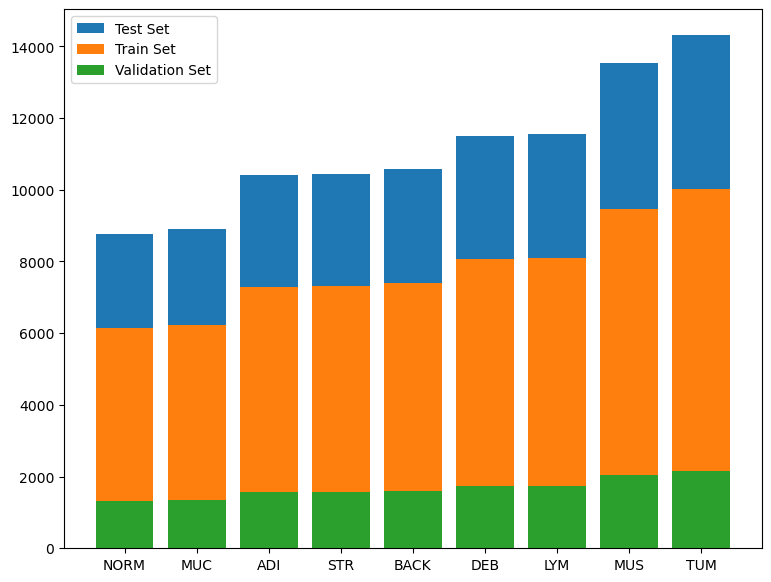

In [23]:
# Check the distribution of data in training and validation sets
train_val_test_data = [train_df, val_df, test_df]
data_names = ['Training', 'Validation', 'Test']

for i, data in enumerate(train_val_test_data):
    class_of_data_patch = data.Class.value_counts()
    print('Class Distribution of {} Examples:\n{}'.format(data_names[i], class_of_data_patch), '\n')
    
# Bar plot for checking the distribution
class_of_train_patch = train_df.Class.value_counts()
class_of_val_patch = val_df.Class.value_counts()
class_of_test_patch = test_df.Class.value_counts()

bar_fig, bar_axis = plt.subplots(figsize=(9,7))

sub_dir_list =  ['NORM', 'MUC', 'ADI', 'STR', 'BACK', 'DEB', 'LYM', 'MUS', 'TUM']

bar_axis.bar(sub_dir_list, class_of_patch[::-1], label='Test Set')
bar_axis.bar(sub_dir_list, class_of_train_patch[::-1], label='Train Set')
bar_axis.bar(sub_dir_list, class_of_val_patch[::-1], label='Validation Set')

bar_axis.legend()


In [7]:
main_dir = '/kaggle/working/SplittedData'
os.makedirs(main_dir, exist_ok=True)

train_dir = os.path.join(main_dir, 'Training')
os.makedirs(train_dir, exist_ok=True)

val_dir = os.path.join(main_dir, 'Validation')
os.makedirs(val_dir, exist_ok=True)

test_dir = os.path.join(main_dir, 'Test')
os.makedirs(test_dir, exist_ok=True)

for cls in sub_dir:
    train_sub_dir = os.path.join(train_dir, cls)
    os.makedirs(train_sub_dir, exist_ok=True)

    val_sub_dir = os.path.join(val_dir, cls)
    os.makedirs(val_sub_dir, exist_ok=True)

    test_sub_dir = os.path.join(test_dir, cls)
    os.makedirs(test_sub_dir, exist_ok=True)


In [8]:
from tqdm import tqdm
import shutil

Data_df.set_index('ID', inplace=True)

for img, label in tqdm(zip(train_df['ID'], train_df['Class']), desc='Copying train images'):
    source = join(main_path, label, img)
    dest = join(train_dir, label)
    shutil.copy(source, dest)

for img, label in tqdm(zip(val_df['ID'], val_df['Class']), desc='Copying validation images'):
    source = join(main_path, label, img)
    dest = join(val_dir, label)
    shutil.copy(source, dest)

for img, label in tqdm(zip(test_df['ID'], test_df['Class']), desc='Copying test images'):
    source = join(main_path, label, img)
    dest = join(test_dir, label)
    shutil.copy(source, dest)


Copying train images: 69999it [13:26, 86.78it/s] 

Copying validation images: 15001it [02:51, 87.23it/s]

Copying test images: 15000it [02:55, 85.31it/s]


In [24]:
img_size = 224
img_channel=3
input_shape=(img_size,img_size,img_channel)
BATCH_size =128
learning_rate = 0.0001
train_step = (len(train_df)/BATCH_size)
val_step = (len(val_df)/BATCH_size)

datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, vertical_flip = True)

train_batches= datagen.flow_from_directory(train_dir,
                                     target_size=(img_size,img_size),
                                     batch_size=BATCH_size,
                                     shuffle = True,
                                     seed = 101,
                                     interpolation = 'nearest',
                                     class_mode='categorical')

validation_batches = datagen.flow_from_directory(val_dir,
                                     target_size=(img_size,img_size),
                                     batch_size=BATCH_size,
                                     shuffle = False,
                                     interpolation = 'nearest',
                                     class_mode='categorical')

test_batches = datagen.flow_from_directory(test_dir,
                                     target_size=(img_size,img_size),
                                     batch_size=BATCH_size,
                                     shuffle = False,
                                     interpolation = 'nearest',
                                     class_mode='categorical')

print(train_batches.class_indices)

Found 69999 images belonging to 9 classes.
Found 15001 images belonging to 9 classes.
Found 7180 images belonging to 9 classes.
{'ADI': 0, 'BACK': 1, 'DEB': 2, 'LYM': 3, 'MUC': 4, 'MUS': 5, 'NORM': 6, 'STR': 7, 'TUM': 8}


# Incorporating attentional mechanisms into the CNN model

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os 
import random 
import cv2

import keras
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras import backend as K
from keras.activations import sigmoid
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from keras import initializers
from keras.models import Sequential

In [36]:
!python --version

Python 3.10.10


In [37]:
print(tf.__version__)
print(keras.__version__)

2.12.0
2.12.0


In [38]:
train_path = "/kaggle/working/SplittedData/Training"
test_path = "/kaggle/working/SplittedData/Test"

<BarContainer object of 9 artists>

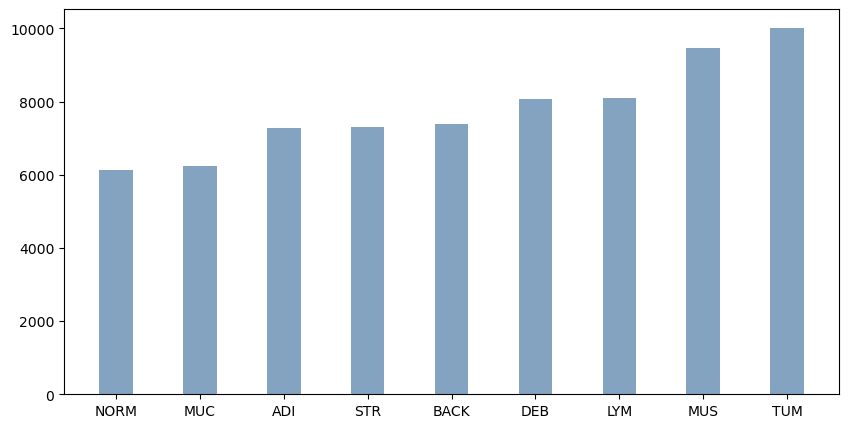

In [40]:

data =  {'NORM':0,
                 'MUC':0,
                 'ADI':0,
                 'STR':0,
                 'BACK':0,
                 'DEB':0,
                 'LYM':0,
                 'MUS':0,
                 'TUM':0}


for cls in os.listdir(train_path):
    for img in os.listdir(train_path + '/' + cls):
        data[cls] = data[cls] + 1

keys = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
plt.bar(keys, values, color=(0.2, 0.4, 0.6, 0.6), width = 0.4)

In [41]:
# METRICS = [keras.metrics.CategoricalAccuracy(name='accuracy'),
#            keras.metrics.Precision(name='precision'),
#            keras.metrics.Recall(name='recall'),
#            keras.metrics.AUC(name='auc')]

METRICS = [keras.metrics.CategoricalAccuracy(name='accuracy')]

In [42]:
EPOCHS = 15
BATCH_SIZE = 128

#### **Incorporation of attention mechanisms**

### Channel Attention: ECA-Net 

In [81]:
def ECA(x):
    k_size = 3 
    squeeze = tf.reduce_mean(x,(2,3),keepdims=False)
    squeeze = tf.expand_dims(squeeze, axis=1)
    
    attn = layers.Conv1D(filters=1,
                         kernel_size=k_size,
                         padding='same',
                         kernel_initializer='random_normal',
                         use_bias=False)(squeeze)
    attn = tf.expand_dims(tf.transpose(attn, [0, 2, 1]), 3)
    attn = tf.math.sigmoid(attn)
    
    scale = x * attn
    return x * attn

In [83]:
inputs = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))

x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = ECA(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = ECA(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = ECA(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = ECA(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = ECA(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(9, activation='softmax')(x)

model_ECA = tf.keras.Model(inputs, output)


In [85]:
model_ECA.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=METRICS)

In [87]:
history_ECA = model_ECA.fit(x=train_batches,
                            validation_data=validation_batches,
                            steps_per_epoch=len(train_batches),
                            validation_steps=len(validation_batches),
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE, 
                            verbose=1)

Epoch 1/15
547/547 [==============================] - 449s 804ms/step - loss: 0.6543 - accuracy: 0.7768 - val_loss: 3.6762 - val_accuracy: 0.1935
Epoch 2/15
547/547 [==============================] - 395s 722ms/step - loss: 0.2984 - accuracy: 0.8966 - val_loss: 0.3580 - val_accuracy: 0.8758
Epoch 3/15
547/547 [==============================] - 419s 765ms/step - loss: 0.2089 - accuracy: 0.9292 - val_loss: 0.3454 - val_accuracy: 0.8837
Epoch 4/15
547/547 [==============================] - 399s 728ms/step - loss: 0.1621 - accuracy: 0.9447 - val_loss: 0.3341 - val_accuracy: 0.8919
Epoch 5/15
547/547 [==============================] - 409s 748ms/step - loss: 0.1364 - accuracy: 0.9549 - val_loss: 0.3357 - val_accuracy: 0.8912
Epoch 6/15
547/547 [==============================] - 392s 716ms/step - loss: 0.1146 - accuracy: 0.9624 - val_loss: 0.2300 - val_accuracy: 0.9241
Epoch 7/15
547/547 [==============================] - 410s 749ms/step - loss: 0.1058 - accuracy: 0.9647 - val_loss: 0.2373 -

In [86]:
model_ECA.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_56 (Conv2D)             (None, 222, 222, 32  896         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 tf.math.reduce_mean_5 (TFOpLam  (None, 222)         0           ['conv2d_56[0][0]']              
 bda)                                                                                       

<Axes: >

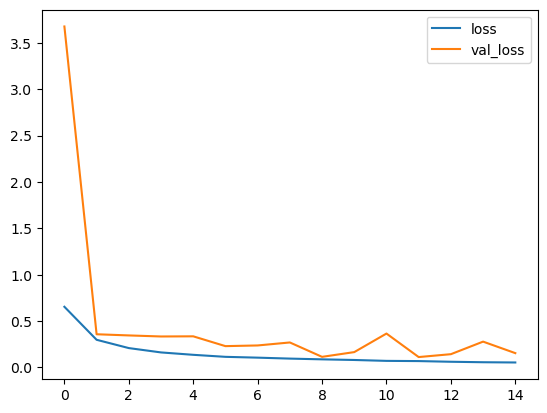

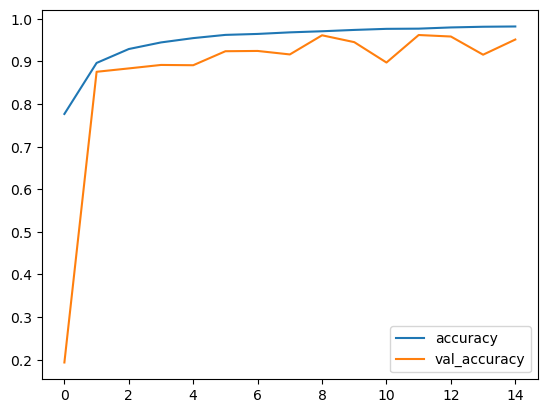

In [88]:
# plot_loss(history_ECA, 0)

hist_df = pd.DataFrame(history_ECA.history)
hist_df.loc[:,['loss','val_loss']].plot()
hist_df.loc[:,['accuracy','val_accuracy']].plot()

In [89]:
results = model_ECA.evaluate(test_batches, verbose=1)

for name, value in zip(model_ECA.metrics_names, results):
    print(name, ': ', value)

57/57 [==============================] - 66s 1s/step - loss: 0.7270 - accuracy: 0.8007
loss :  0.7270194292068481
accuracy :  0.8006963729858398


57/57 [==============================] - 50s 878ms/step
              precision    recall  f1-score   support

           0       0.85      0.66      0.74      1338
           1       0.99      1.00      0.99       847
           2       0.61      0.83      0.70       339
           3       0.96      0.82      0.88       634
           4       0.99      0.84      0.91      1035
           5       0.43      0.59      0.50       592
           6       0.82      0.73      0.78       741
           7       0.54      0.75      0.63       421
           8       0.87      0.95      0.91      1233

    accuracy                           0.80      7180
   macro avg       0.78      0.80      0.78      7180
weighted avg       0.83      0.80      0.81      7180



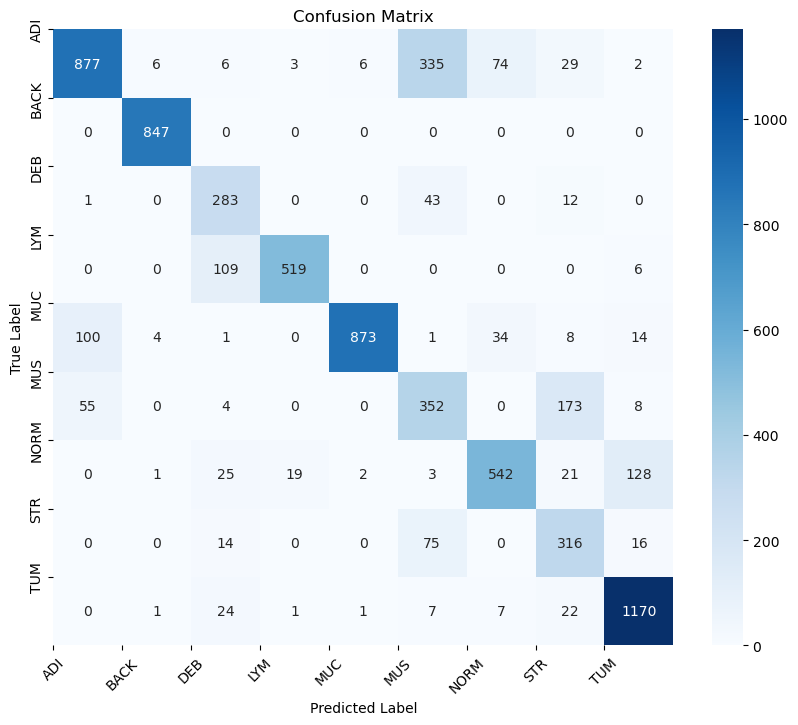

In [90]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get the predictions for the test data
predictions = model_ECA.predict(test_batches)

# Convert the predictions and true labels to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_batches.labels

# Calculate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Calculate additional evaluation metrics
report = classification_report(true_classes, predicted_classes)
print(report)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(test_batches.class_indices)), test_batches.class_indices, rotation=45)
plt.yticks(np.arange(len(test_batches.class_indices)), test_batches.class_indices)
plt.show()


Found 7180 images belonging to 9 classes.
57/57 [==============================] - 24s 429ms/step
              precision    recall  f1-score   support

           0       0.85      0.65      0.73      1338
           1       0.99      1.00      0.99       847
           2       0.59      0.83      0.69       339
           3       0.94      0.81      0.87       634
           4       0.99      0.84      0.91      1035
           5       0.42      0.59      0.49       592
           6       0.83      0.72      0.77       741
           7       0.56      0.76      0.64       421
           8       0.87      0.95      0.90      1233

    accuracy                           0.80      7180
   macro avg       0.78      0.79      0.78      7180
weighted avg       0.83      0.80      0.81      7180



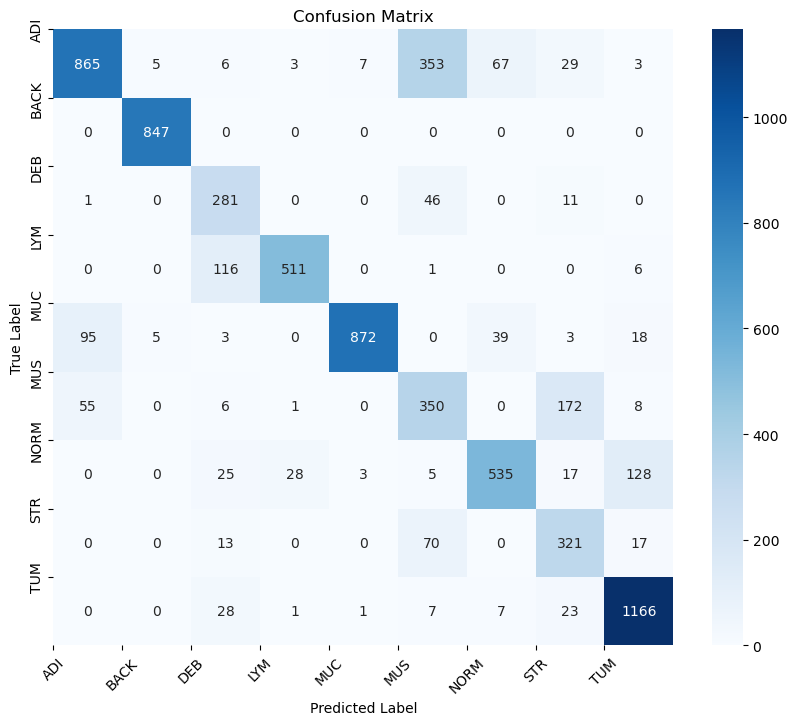

In [91]:
# Assuming test_batches IS crc-val-he-7k
test_dir = "/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K"
test_batches_7k = datagen.flow_from_directory(test_dir,
                                     target_size=(img_size,img_size),
                                     batch_size=BATCH_size,
                                     shuffle = False,
                                     interpolation = 'nearest',
                                     class_mode='categorical')

# Get the predictions for the test data
predictions = model_ECA.predict(test_batches_7k)

# Convert the predictions and true labels to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_batches_7k.labels

# Calculate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Calculate additional evaluation metrics
report = classification_report(true_classes, predicted_classes)
print(report)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(test_batches_7k.class_indices)), test_batches_7k.class_indices, rotation=45)
plt.yticks(np.arange(len(test_batches_7k.class_indices)), test_batches_7k.class_indices)
plt.show()


In [92]:
results = model_ECA.evaluate(test_batches_7k, verbose=1)

for name, value in zip(model_ECA.metrics_names, results):
    print(name, ': ', value)

57/57 [==============================] - 24s 416ms/step - loss: 0.7243 - accuracy: 0.7982
loss :  0.724329948425293
accuracy :  0.7981894016265869


### Channel & Spatial Attention: CBAM 

In [58]:
# =================================================================== CBAM ==============
def cbam_block(cbam_feature, ratio=8):
    
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

# =================================================================== CAM ===============
def channel_attention(input_feature, ratio=8):
    
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

# =================================================================== SAM ===============
def spatial_attention(input_feature):
    kernel_size = 7
    
    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)	
    assert cbam_feature.shape[-1] == 1
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

In [59]:
IMG_SIZE = 224
n_classes = 9

In [67]:
inputs = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))

x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = cbam_block(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
# ===========================================================

x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = cbam_block(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
# ===========================================================

x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = cbam_block(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
# ===========================================================

x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = cbam_block(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
# ===========================================================

x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = cbam_block(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
# ===========================================================

x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(9, activation='softmax')(x)

model_CBAM = tf.keras.Model(inputs, output)
# model = Model(inputs, output)

In [68]:
model_CBAM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                   loss='categorical_crossentropy', 
                   metrics=METRICS)

In [69]:
# callbacks
from tensorflow.keras.callbacks import ModelCheckpoint,  ReduceLROnPlateau

saved_model_path = 'history_CBAM.h5'
checkpoint = ModelCheckpoint(saved_model_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.3, 
                              patience=2, 
                              verbose=1,
                              mode='max',
                              min_delta=0.001,
                              min_lr=0.0000001)

In [70]:
history_CBAM = model_CBAM.fit(x=train_batches,
                              validation_data=validation_batches,
                              steps_per_epoch=len(train_batches),
                              validation_steps=len(validation_batches),
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE, 
                              verbose=1,
                              callbacks=[checkpoint, reduce_lr])

Epoch 1/15
547/547 [==============================] - ETA: 0s - loss: 0.5203 - accuracy: 0.7903
Epoch 1: val_loss improved from inf to 2.10736, saving model to history_CBAM.h5
547/547 [==============================] - 503s 896ms/step - loss: 0.5203 - accuracy: 0.7903 - val_loss: 2.1074 - val_accuracy: 0.2658 - lr: 1.0000e-04
Epoch 2/15
547/547 [==============================] - ETA: 0s - loss: 0.2301 - accuracy: 0.9230
Epoch 2: val_loss improved from 2.10736 to 0.24762, saving model to history_CBAM.h5
547/547 [==============================] - 394s 719ms/step - loss: 0.2301 - accuracy: 0.9230 - val_loss: 0.2476 - val_accuracy: 0.9193 - lr: 1.0000e-04
Epoch 3/15
547/547 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.9470
Epoch 3: val_loss did not improve from 0.24762
547/547 [==============================] - 415s 758ms/step - loss: 0.1571 - accuracy: 0.9470 - val_loss: 0.4362 - val_accuracy: 0.8517 - lr: 1.0000e-04
Epoch 4/15
547/547 [=========================

In [71]:
model_CBAM.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_29 (Conv2D)             (None, 222, 222, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 global_average_pooling2d_5 (Gl  (None, 32)          0           ['conv2d_29[0][0]']              
 obalAveragePooling2D)                                                                      

<Axes: >

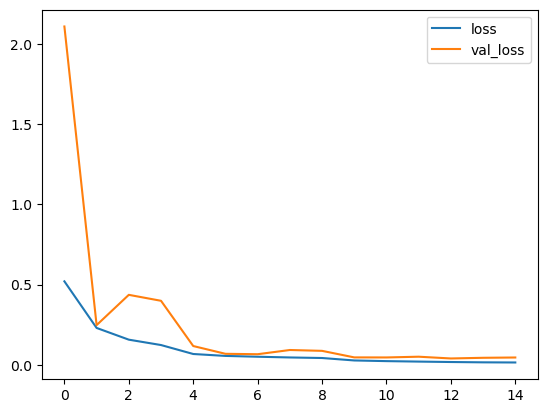

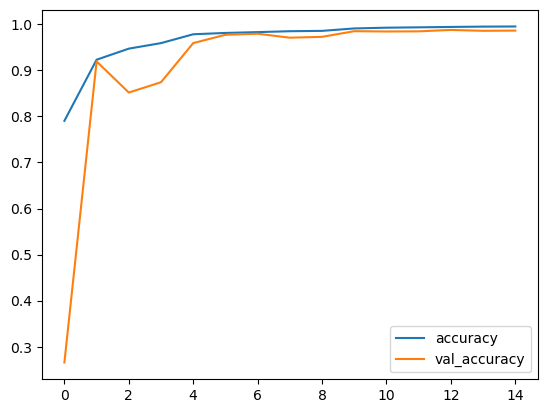

In [72]:
# plot_loss(history_CBAM, 0)

hist_df = pd.DataFrame(history_CBAM.history)
hist_df.loc[:,['loss','val_loss']].plot()
hist_df.loc[:,['accuracy','val_accuracy']].plot()

# Test (NCT-CRC-HE-100K)

In [73]:
results = model_CBAM.evaluate(test_batches, verbose=1)

for name, value in zip(model_CBAM.metrics_names, results):
    print(name, ': ', value)
    

57/57 [==============================] - 69s 1s/step - loss: 0.6123 - accuracy: 0.8767
loss :  0.612321674823761
accuracy :  0.8767409324645996


57/57 [==============================] - 49s 850ms/step
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1338
           1       0.94      1.00      0.97       847
           2       0.49      0.97      0.65       339
           3       0.97      0.76      0.85       634
           4       0.96      0.94      0.95      1035
           5       0.75      0.80      0.77       592
           6       0.90      0.86      0.88       741
           7       0.78      0.52      0.63       421
           8       0.91      0.93      0.92      1233

    accuracy                           0.88      7180
   macro avg       0.85      0.85      0.84      7180
weighted avg       0.90      0.88      0.88      7180



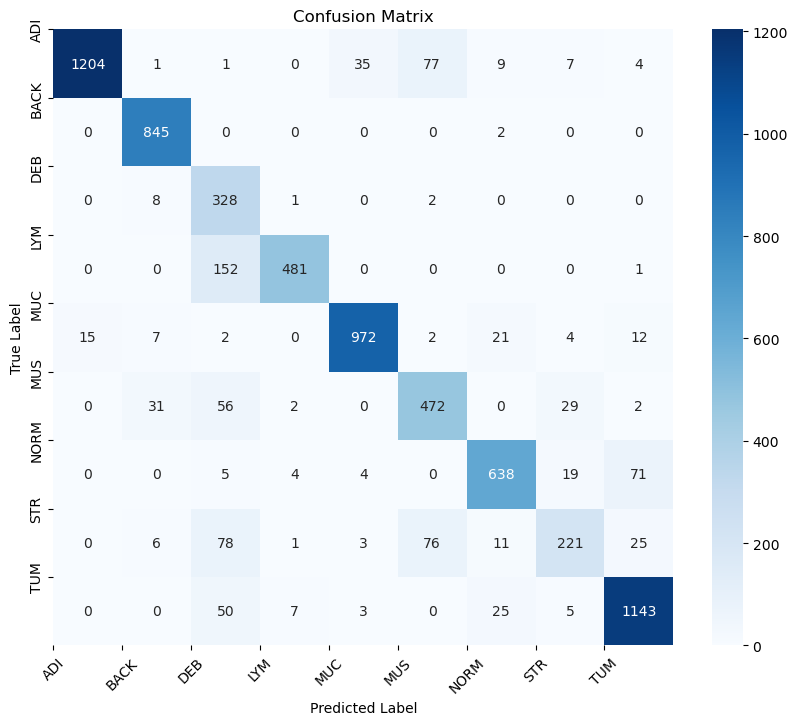

In [74]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get the predictions for the test data
predictions = model_CBAM.predict(test_batches)

# Convert the predictions and true labels to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_batches.labels

# Calculate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Calculate additional evaluation metrics
report = classification_report(true_classes, predicted_classes)
print(report)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(test_batches.class_indices)), test_batches.class_indices, rotation=45)
plt.yticks(np.arange(len(test_batches.class_indices)), test_batches.class_indices)
plt.show()


# Test (CRC-VAL-HE-7K)

Found 7180 images belonging to 9 classes.
57/57 [==============================] - 24s 426ms/step
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1338
           1       0.94      1.00      0.97       847
           2       0.49      0.96      0.65       339
           3       0.96      0.76      0.85       634
           4       0.95      0.94      0.95      1035
           5       0.76      0.80      0.78       592
           6       0.92      0.85      0.88       741
           7       0.78      0.53      0.63       421
           8       0.90      0.92      0.91      1233

    accuracy                           0.88      7180
   macro avg       0.85      0.85      0.84      7180
weighted avg       0.90      0.88      0.88      7180



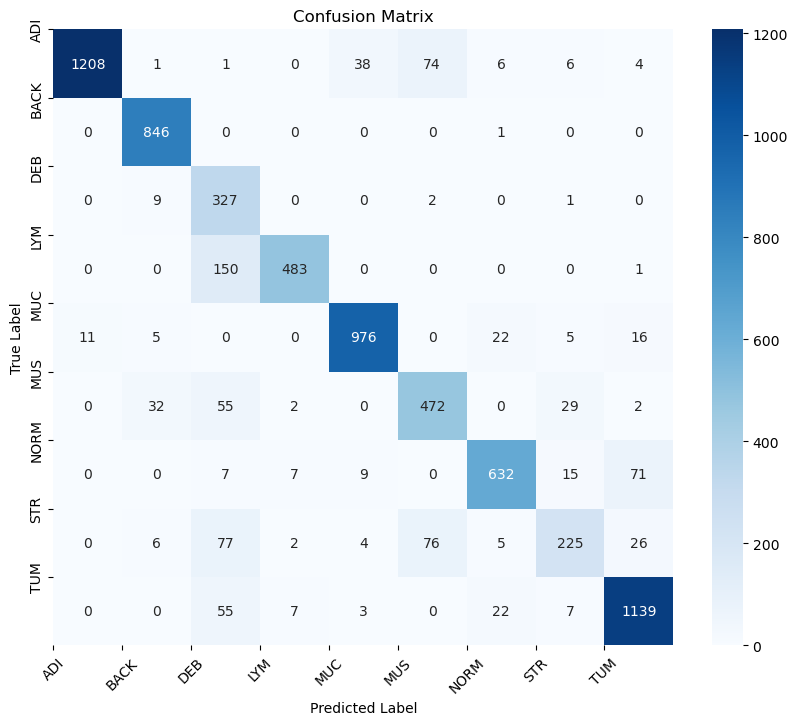

In [75]:
# Assuming test_batches IS crc-val-he-7k
test_dir = "/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K"
test_batches_7k = datagen.flow_from_directory(test_dir,
                                     target_size=(img_size,img_size),
                                     batch_size=BATCH_size,
                                     shuffle = False,
                                     interpolation = 'nearest',
                                     class_mode='categorical')

# Get the predictions for the test data
predictions = model_CBAM.predict(test_batches_7k)

# Convert the predictions and true labels to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_batches_7k.labels

# Calculate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Calculate additional evaluation metrics
report = classification_report(true_classes, predicted_classes)
print(report)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(test_batches_7k.class_indices)), test_batches_7k.class_indices, rotation=45)
plt.yticks(np.arange(len(test_batches_7k.class_indices)), test_batches_7k.class_indices)
plt.show()


In [93]:
results = model_ECA.evaluate(test_batches_7k, verbose=1)

for name, value in zip(model_CBAM.metrics_names, results):
    print(name, ': ', value)

57/57 [==============================] - 24s 418ms/step - loss: 0.7352 - accuracy: 0.8022


In [76]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = tf.keras.Model(
        inputs=[self.model.inputs],
        outputs=[self.model.get_layer(self.layerName).output,
                 self.model.output])
        
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        image = np.asarray(image, np.float64)
        heatmap = np.asarray(heatmap, np.float64)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        return (heatmap, output)

In [77]:
def show_heatmap(model, img_path):
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    preds = model.predict(image)
    i = np.argmax(preds[0])
    
    label_to_class =  {'NORM':0,
                 'MUC':1,
                 'ADI':2,
                 'STR':3,
                 'BACK':4,
                 'DEB':5,
                 'LYM':6,
                 'MUS':7,
                 'TUM':8}
    
    class_to_label = {v: k for k, v in label_to_class.items()}

    label = class_to_label[i]
    print(f'Predicted class: {label} | Prediction probability: {max(preds[0]) * 100}%')
    
    cam = GradCAM(model, i)
    heatmap = cam.compute_heatmap(image)

    (heatmap, output) = cam.overlay_heatmap(heatmap, image[0], alpha=0.5)
    
    output = output.astype(np.uint8)
    plt.imshow(output, interpolation='nearest')
    plt.show()

In [78]:
# img_path = "../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/MildDemented/mildDem0.jpg"
# show_heatmap(model, img_path)

In [79]:
# img_path = "../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/MildDemented/mildDem0.jpg"
# show_heatmap(model_ECA, img_path)

1/1 [==============================] - 1s 1s/step
Predicted class: LYM | Prediction probability: 99.99997615814209%


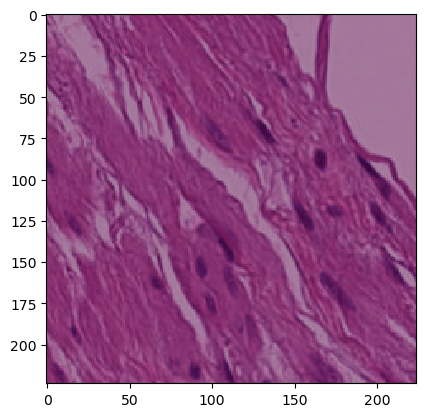

In [80]:
img_path = "/kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K/MUS/MUS-AADNSWYC.tif"
show_heatmap(model_CBAM, img_path)

# Citation : 
#### => Inspired from : https://www.kaggle.com/code/nefelimyro/cnn-with-attention by NEFELI MYRO
#### => Implementation of Convolutional Block Attention Module(CBAM) block. As described in https://arxiv.org/abs/1807.06521.